In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [2]:
file_path= './data/market-price.csv'
bitcoin_df=pd.read_csv(file_path, names = ['day','price']) # csv를 읽어올때 names는 칼럼을 생성

In [3]:
# 기본 정보를 출력합니다.
print(bitcoin_df.head())
print(bitcoin_df.shape)
print(bitcoin_df.info())

                   day        price
0  2017-08-27 00:00:00  4354.308333
1  2017-08-28 00:00:00  4391.673517
2  2017-08-29 00:00:00  4607.985450
3  2017-08-30 00:00:00  4594.987850
4  2017-08-31 00:00:00  4748.255000
(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


### [시계열 데이터 살펴보기]

In [5]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다.
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터프레임을 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [6]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


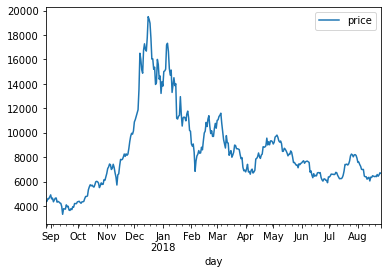

In [7]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

#### ARIMA 모델 학습

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AT=2, 차분=1, MA=2) 파라미터로 ARIMA모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2)) # (AT=2, 차분=1, MA=2)
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Thu, 22 Apr 2021   AIC                           5587.107
Time:                        14:51:08   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3502     27.794      0.228      0.819     -48.125      60.826
ar.L1.D.y     -0.3788      1.827     -0.207      0.836      -3.960       3.203
ar.L2.D.y      0.1585      1.191      0.133      0.8

#### 모델의 성능 & 예측 결과 시각화
#### - 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

<AxesSubplot:>

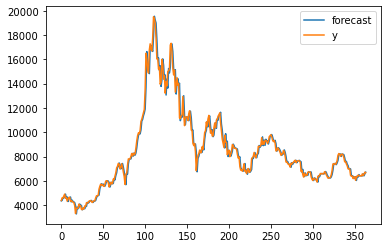

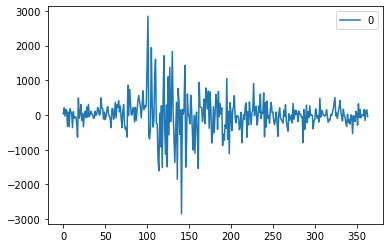

In [9]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

#### 실제 데이터와의 비교
####        - 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.

In [10]:
forecast_data= model_fit.forecast(steps = 5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# # 테스트 데이터셋을 불러옵니다.
test_file_path = './data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다.(2018-08-27 ~ 2018-08-31) (예측한데이터)
test_y = bitcoin_test_df.y.values  # 실제 5일 가격 데이터입니다.(불러온데이터)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)


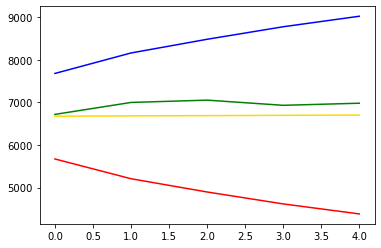

In [11]:
plt.plot(pred_y, color = 'gold') # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color='red') # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color='blue') # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color='green') # 실제 가격 그래프입니다.

#### [Facebook Prophet 활용하기]

#### 1. 설치방법 conda install -c conda-forge fbprophet
#### 2. prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다. 

In [12]:
from fbprophet import Prophet

In [13]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야합니다
bitcoin_df = pd.read_csv(file_path, names = ['ds','y'])
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality =True,
                 weekly_seasonality = True, daily_seasonality = True,
                 changepoint_prior_scale = 0.5)
prophet.fit(bitcoin_df)

#### 모델로부터 예측할 기간을 정의하고, 결과를 도출

In [14]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data=prophet.predict(future_data) 

In [15]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,798.936686,6228.031252,7580.985869,798.936686,798.936686,8.968437,8.968437,8.968437,7.636134,...,-0.006461,-0.006461,-0.006461,-1.325842,-1.325842,-1.325842,0.0,0.0,0.0,6899.724550
366,2018-08-28,803.275432,6319.187405,7630.011689,803.275432,803.275432,8.968437,8.968437,8.968437,7.701947,...,0.017381,0.017381,0.017381,-1.283871,-1.283871,-1.283871,0.0,0.0,0.0,6990.060163
367,2018-08-29,807.614178,6327.739318,7704.721162,807.614178,807.614178,8.968437,8.968437,8.968437,7.668899,...,-0.042695,-0.042695,-0.042695,-1.256844,-1.256844,-1.256844,0.0,0.0,0.0,7001.125569
368,2018-08-30,811.952923,6362.702702,7772.647445,809.805800,814.113173,8.968437,8.968437,8.968437,7.707693,...,-0.013228,-0.013228,-0.013228,-1.247516,-1.247516,-1.247516,0.0,0.0,0.0,7070.236574
369,2018-08-31,816.291669,6408.931997,7864.309010,806.267287,828.292736,8.968437,8.968437,8.968437,7.744832,...,0.034494,0.034494,0.034494,-1.258099,-1.258099,-1.258099,0.0,0.0,0.0,7138.333532


#### 결과의 시각화
#### - 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

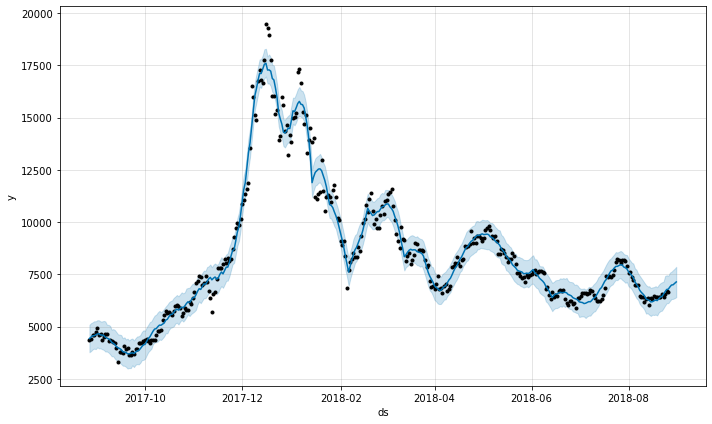

In [16]:
fig1 = prophet.plot(forecast_data)

#### -  seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

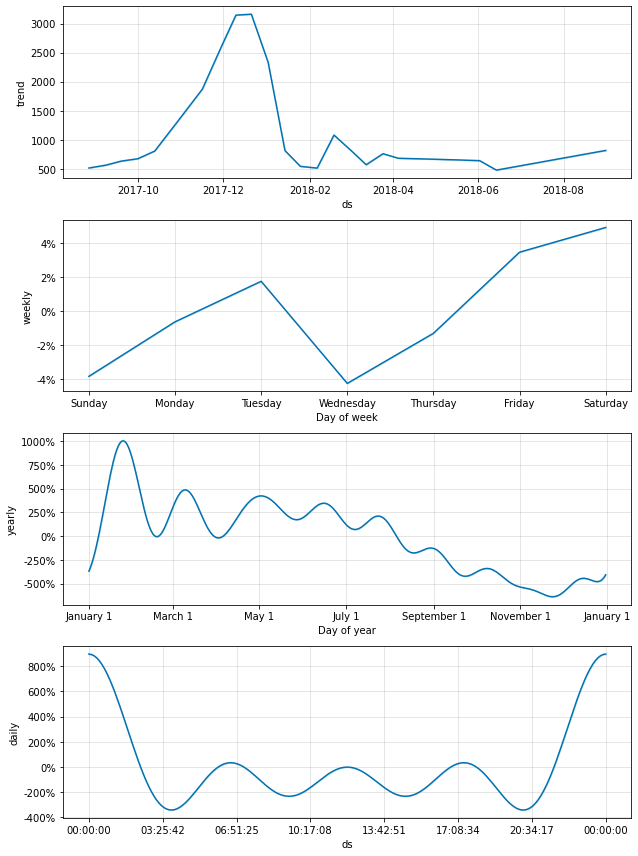

In [17]:
fig2 = prophet.plot_components(forecast_data)

#### 모델의 성능
#### -  실제가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.


In [18]:
y = bitcoin_df.y.values[5:]
y_pred = forecast_data.yhat.values[5:-5]

In [19]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다.(2018-08-27 ~ 2018-08-31) (예측한데이터)
test_y = bitcoin_test_df.y.values  # 실제 5일 가격 데이터입니다.(불러온데이터)
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

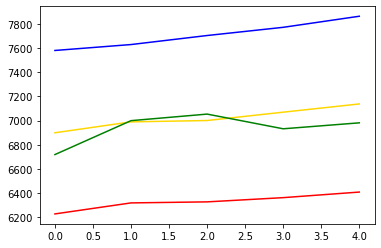

In [20]:
plt.plot(pred_y, color = 'gold') # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color='red') # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color='blue') # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color='green') # 실제 가격 그래프입니다.

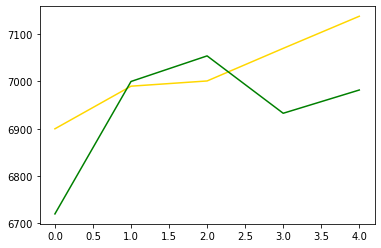

In [21]:
# 5일동안의 경향성 파악
plt.plot(pred_y, color = 'gold') # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color='green') # 실제 가격 그래프입니다.